In [1]:
import os
import time
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from aesvdd import autoencoder
from aesvdd import model
from aesvdd import datasets

import warnings
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(os.getcwd())
warnings.filterwarnings("ignore")


Instructions for updating:
non-resource variables are not supported in the long term
/home/kael99/Documents/Code/Autoencoder_SVDD


In [2]:
X_train, X_test, y_test = datasets.get_mnist(1)

In [3]:
tf.reset_default_graph()
AE_model = autoencoder.mnist_lenet(H=32)
#pre_train_AE (not required)
# AE_model.compile(optimizer='adam', loss='mse')
# AE_model.fit(X_train, X_train, epochs=2, batch_size=128, validation_data=(X_test, X_test), verbose=True)

In [4]:
inputs = AE_model.input
outputs = AE_model.get_layer(name="code_layer").output
encoder = Model(inputs = inputs, outputs = outputs)

In [5]:
# build model and DeepSVDD
svdd_hard = model.AESVDD(encoder, input_shape=((28,28,1)), representation_dim=32, objective='hard', nu=0.02, lr=5e-4)
t0 = time.time()
hisory = svdd_hard.fit(X_train, X_test, y_test, epochs=10, verbose=True)
print('Train time:', time.time() - t0)

# test DeepSVDD
t0 = time.time()
score = svdd_hard.predict(X_test)
auc = roc_auc_score(y_test, -score)
print('Test time:', time.time() - t0)
print('------------- AUROC ----------- : %.4f' % auc)


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


  4%|▍         | 2/53 [00:00<00:03, 13.41it/s]

Epoch:   0 AUROC: 0.991


  4%|▍         | 2/53 [00:00<00:03, 16.29it/s]

Epoch:   1 AUROC: 0.993


  4%|▍         | 2/53 [00:00<00:03, 16.43it/s]

Epoch:   2 AUROC: 0.992


  4%|▍         | 2/53 [00:00<00:03, 13.51it/s]

Epoch:   3 AUROC: 0.991


  2%|▏         | 1/53 [00:00<00:05,  9.97it/s]

Epoch:   4 AUROC: 0.991


  2%|▏         | 1/53 [00:00<00:05,  9.11it/s]

Epoch:   5 AUROC: 0.991


  4%|▍         | 2/53 [00:00<00:03, 13.92it/s]

Epoch:   6 AUROC: 0.991


  4%|▍         | 2/53 [00:00<00:03, 13.43it/s]

Epoch:   7 AUROC: 0.991


  2%|▏         | 1/53 [00:00<00:05,  9.67it/s]

Epoch:   8 AUROC: 0.991


100%|██████████| 53/53 [00:04<00:00, 13.15it/s]


Epoch:   9 AUROC: 0.991
Train time: 63.29933166503906
Test time: 2.099440813064575
------------- AUROC ----------- : 0.9913


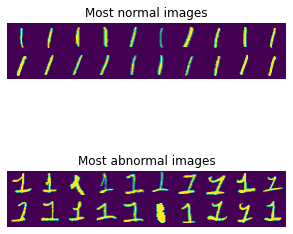

In [6]:
from aesvdd.utils import plot_most_normal_and_abnormal_images
score_1 = svdd_hard.predict(X_train) 
plot_most_normal_and_abnormal_images(X_train, score_1)
plt.show()


In [7]:
svdd_hard.save_model("svdd_hard_mnist")

In [8]:
X_train_map = svdd_hard.keras_model.predict(X_train)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [9]:
X_train_map.shape

(6742, 32)

In [10]:
y_train_label = svdd_hard.predict_label(X_train)

In [11]:
np.unique(y_train_label, return_counts=True)

(array([-1,  1]), array([ 135, 6607]))

In [12]:
from sklearn.decomposition import PCA
X_map_2D = PCA(n_components=2).fit_transform(X_train_map)

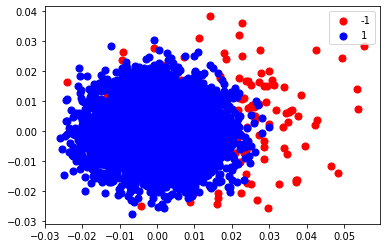

In [22]:
cdict = {-1: 'red', 1: 'blue'}
fig, ax = plt.subplots()
for g in np.unique(y_train_label):
    ix = np.where(y_train_label == g)
    ax.scatter(X_map_2D[:,0][ix], X_map_2D[:,1][ix], c = cdict[g], label = g, s = 50)
ax.legend()
plt.show()